# 2023-02-13

## 포트폴리오 & 금융데이터 분석

### [실습] 수익률 계산하기

In [2]:
!pip install finance-datareader

In [2]:
import numpy as np
import pandas as pd
import FinanceDataReader as fdr

# 실습 데이터 - 테슬라오와 nvdia 데이터를 resample하여 월 단위 종가(int로 형변환)를 가져옴

s1_ticker = 'TSLA'
s2_ticker = 'NVDA'
s1 = fdr.DataReader(s1_ticker, '2018').resample(rule = 'M').mean().astype(int)[['Close']]
s2 = fdr.DataReader(s2_ticker, '2018').resample(rule = 'M').mean().astype(int)[['Close']]
s1.head()

,Close
Date,
2018-01-31,22
2018-02-28,22
2018-03-31,21
2018-04-30,19
2018-05-31,19


### 단순 수익률

In [7]:
# 수익률 : (나중 가격 - 이전 가격) / 이전 가격

s1[s1_ticker] = s1['Close'].pct_change()                # pct_change()함수 이용
s2[s2_ticker] = s2['Close'] / s2['Close'].shift(1) - 1  # 수식으로 수익률 구하기 

In [8]:
s1.head()

,Close,TSLA
Date,,
2018-01-31,22,NaN
2018-02-28,22,0.000000
2018-03-31,21,-0.045455
2018-04-30,19,-0.095238
2018-05-31,19,0.000000


In [11]:
# s1, s2 수익률 컬럼 합치기 (NaN 제거)

changes = pd.concat([s1[s1_ticker], s2[s2_ticker]], axis = 1).dropna()
changes.head()

,TSLA,NVDA
Date,,
2018-02-28,0.000000,0.053571
2018-03-31,-0.045455,0.016949
2018-04-30,-0.095238,-0.066667
2018-05-31,0.000000,0.089286
2018-06-30,0.157895,0.049180


In [12]:
# TSLA(s1)의 수익률의 평균과 risk(표준편차) 구하기

print(s1[s1_ticker].mean())
print(s1[s1_ticker].std())      # s1이 risk가 s2보다 살짝 높다고 볼 수 있다.

0.05138906330621972
0.18286233305286992


In [13]:
# NVDA(s2)의 수익률의 평균과 risk(표준편차) 구하기

print(s2[s2_ticker].mean())
print(s2[s2_ticker].std())

0.029531695755656475
0.12054798622182465


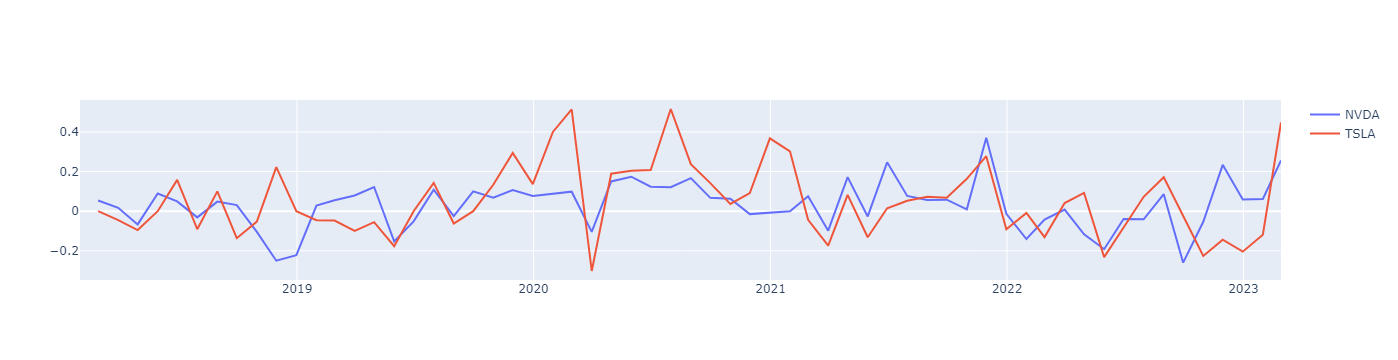

In [25]:
# changes 시각화

import plotly.graph_objects as go

# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=s2.index, y=s2[s2_ticker],
                        mode='lines',
                        name=s2_ticker))
fig.add_trace(go.Scatter(x=s1.index, y=s1[s1_ticker],
                        mode='lines',
                        name=s1_ticker))
fig.show()

### 복리수익률

In [50]:
# 누적 수익률

누적수익률 = (changes + 1).cumprod() - 1   # 누적곱 함수 : cumprod()
누적수익률.tail()

,TSLA,NVDA
Date,,
2022-10-31,9.136364,1.214286
2022-11-30,7.681818,1.732143
2022-12-31,5.909091,1.892857
2023-01-31,5.090909,2.071429
2023-02-28,7.818182,2.857143


In [52]:
# 투자년도 구하기

누적수익률.index.min()

Timestamp('2018-02-28 00:00:00', freq='M')

In [53]:
누적수익률.index.max()

Timestamp('2023-02-28 00:00:00', freq='M')

In [54]:
# 복리 수익률 (1 + 누적수익률)**(1 / 투자년도) - 1

CAGR = (1 + 누적수익률) ** ( 1 / (len(누적수익률.index) / 12) ) - 1
CAGR.tail()   # 마지막 row가 복리 수익률

,TSLA,NVDA
Date,,
2022-10-31,0.577170,0.169270
2022-11-30,0.529835,0.218623
2022-12-31,0.462622,0.232403
2023-01-31,0.426802,0.247011
2023-02-28,0.534533,0.304160


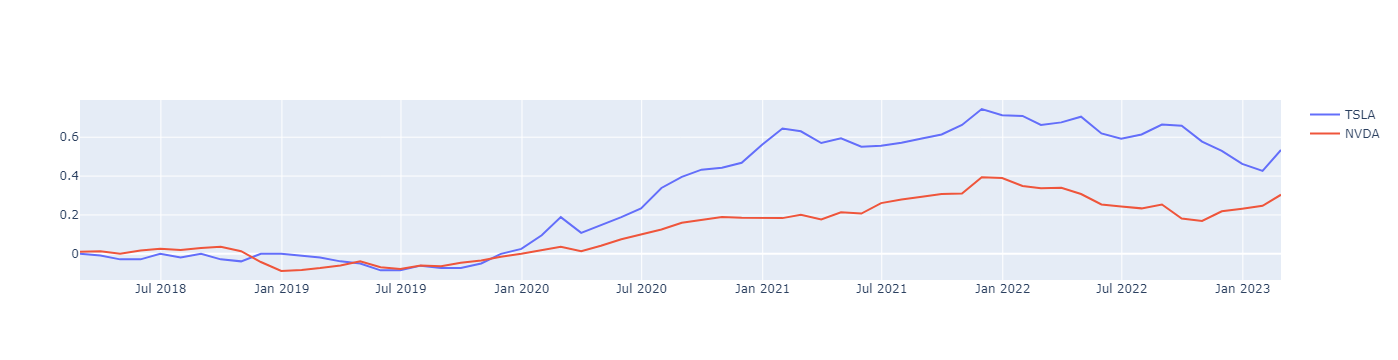

In [55]:
# 시각화

fig = go.Figure()
fig.add_trace(go.Scatter(x=CAGR.index, y=CAGR[s1_ticker],
                        mode='lines',
                        name=s1_ticker))
fig.add_trace(go.Scatter(x=CAGR.index, y=CAGR[s2_ticker],
                        mode='lines',
                        name=s2_ticker))
fig.show()

### 로그 수익률

In [27]:
# 로그(종가) - 로그(종가).shift(1)

s1['LogReturn'] = np.log(s1['Close']) - np.log(s1['Close']).shift(1)
s2['LogReturn'] = np.log(s2['Close']) - np.log(s2['Close']).shift(1)
s1.head()

,Close,TSLA,LogReturn
Date,,,
2018-01-31,22,NaN,NaN
2018-02-28,22,0.000000,0.000000
2018-03-31,21,-0.045455,-0.046520
2018-04-30,19,-0.095238,-0.100083
2018-05-31,19,0.000000,0.000000


In [32]:
# 로그 수익률(복리)이므로 모두 더해 주어야 전체 수익률을 구할 수 있음

s1['Cum_LogReturn'] = s1['LogReturn'].cumsum()       # cumsum() : 누적합 함수
s2['Cum_LogReturn'] = s2['LogReturn'].cumsum()

# 단리 수익률

s1['Return'] = (1 + s1[s1_ticker]).cumprod() - 1
s2['Return'] = (1 + s2[s2_ticker]).cumprod() - 1

s1.tail()

,Close,TSLA,LogReturn,Cum_LogReturn,Return
Date,,,,,
2022-10-31,223,-0.225694,-0.255789,2.316129,9.136364
2022-11-30,191,-0.143498,-0.154898,2.161231,7.681818
2022-12-31,152,-0.204188,-0.228393,1.932838,5.909091
2023-01-31,134,-0.118421,-0.126041,1.806797,5.090909
2023-02-28,194,0.447761,0.370018,2.176816,7.818182


### 실습

In [3]:
samsung = fdr.DataReader('005930', '1998').resample(rule = 'M').mean().astype(int)[['Close']]
samsung

,Close
Date,
1998-11-30,1243
1998-12-31,1418
1999-01-31,1740
1999-02-28,1680
1999-03-31,1759
...,...
2022-10-31,56710
2022-11-30,61090
2022-12-31,59080


In [5]:
# 수익률

samsung['수익률'] = samsung[['Close']].pct_change().dropna()
samsung

,Close,수익률
Date,,
1998-11-30,1243,NaN
1998-12-31,1418,0.140788
1999-01-31,1740,0.227080
1999-02-28,1680,-0.034483
1999-03-31,1759,0.047024
...,...,...
2022-10-31,56710,0.020056
2022-11-30,61090,0.077235
2022-12-31,59080,-0.032902


In [6]:
# 누적수익률

samsung['누적수익률'] = (samsung['수익률'] + 1).cumprod() - 1 
samsung

,Close,수익률,누적수익률
Date,,,
1998-11-30,1243,NaN,NaN
1998-12-31,1418,0.140788,0.140788
1999-01-31,1740,0.227080,0.399839
1999-02-28,1680,-0.034483,0.351569
1999-03-31,1759,0.047024,0.415125
...,...,...,...
2022-10-31,56710,0.020056,44.623492
2022-11-30,61090,0.077235,48.147224
2022-12-31,59080,-0.032902,46.530169


In [7]:
# 연복리수익률(CAGR)

samsung['연복리수익률'] = (1 + samsung['누적수익률']) ** ( 1 / (len(samsung['누적수익률'].index) / 12) ) - 1
samsung.tail()

,Close,수익률,누적수익률,연복리수익률
Date,,,,
2022-10-31,56710,0.020056,44.623492,0.170000
2022-11-30,61090,0.077235,48.147224,0.173583
2022-12-31,59080,-0.032902,46.530169,0.171970
2023-01-31,60540,0.024712,47.704747,0.173146
2023-02-28,62711,0.035861,49.451327,0.174846


In [8]:
# 로그 수익률

samsung['LogReturn'] = np.log(samsung['Close']) - np.log(samsung['Close']).shift(1)
samsung.head()

,Close,수익률,누적수익률,연복리수익률,LogReturn
Date,,,,,
1998-11-30,1243,NaN,NaN,NaN,NaN
1998-12-31,1418,0.140788,0.140788,0.005428,0.131720
1999-01-31,1740,0.227080,0.399839,0.013919,0.204638
1999-02-28,1680,-0.034483,0.351569,0.012458,-0.035091
1999-03-31,1759,0.047024,0.415125,0.014372,0.045952


In [9]:
# 누적 로그 수익률

samsung['Cum_LogReturn'] = samsung['LogReturn'].cumsum()
samsung

,Close,수익률,누적수익률,연복리수익률,LogReturn,Cum_LogReturn
Date,,,,,,
1998-11-30,1243,NaN,NaN,NaN,NaN,NaN
1998-12-31,1418,0.140788,0.140788,0.005428,0.131720,0.131720
1999-01-31,1740,0.227080,0.399839,0.013919,0.204638,0.336357
1999-02-28,1680,-0.034483,0.351569,0.012458,-0.035091,0.301266
1999-03-31,1759,0.047024,0.415125,0.014372,0.045952,0.347218
...,...,...,...,...,...,...
2022-10-31,56710,0.020056,44.623492,0.170000,0.019857,3.820423
2022-11-30,61090,0.077235,48.147224,0.173583,0.074398,3.894820
2022-12-31,59080,-0.032902,46.530169,0.171970,-0.033456,3.861365


### 증권 데이터 분석

In [75]:
!pip install finance-datareader

In [1]:
import numpy as np
import pandas as pd
import FinanceDataReader as fdr

# 실습 데이터 - MS soft와 애플, nvdia 데이터를 rename하여 column명을 ticker명으로 바꾸고 종가 데이터를 가져옴

s1_ticker = 'MSFT'
s2_ticker = 'AAPL'
s3_ticker = 'NVDA'
s1 = fdr.DataReader(s1_ticker, '2018')[['Close']].rename(columns = {'Close' : s1_ticker})
s2 = fdr.DataReader(s2_ticker, '2018')[['Close']].rename(columns = {'Close' : s2_ticker})
s3 = fdr.DataReader(s3_ticker, '2018')[['Close']].rename(columns = {'Close' : s3_ticker})

# s1, s2, s3를 concat하여 붙임

stocks = pd.concat([s1, s2, s3], axis = 1)
stocks.head()

,MSFT,AAPL,NVDA
Date,,,
2018-01-02,85.949997,43.064999,49.837502
2018-01-03,86.349998,43.057499,53.117500
2018-01-04,87.110001,43.257500,53.397499
2018-01-05,88.190002,43.750000,53.849998
2018-01-08,88.279999,43.587502,55.500000


<AxesSubplot: xlabel='Date'>

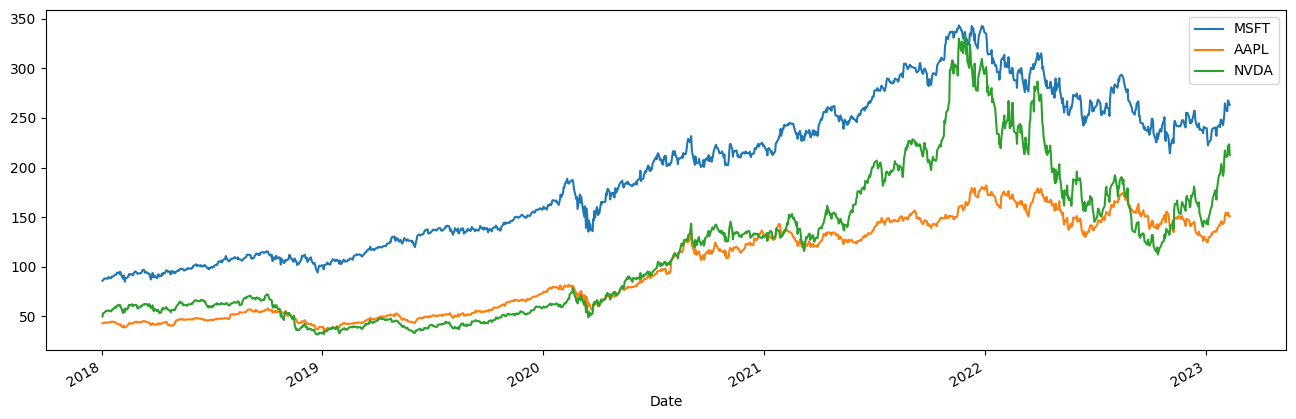

In [8]:
# 시각화

stocks.plot(figsize = (16, 5))

In [9]:
# 최고점

stocks.idxmax(axis=0)

MSFT   2021-11-19
AAPL   2022-01-03
NVDA   2021-11-29
dtype: datetime64[ns]

In [10]:
# 최고가격

stocks.max(axis=0)

MSFT    343.109985
AAPL    182.009995
NVDA    333.760010
dtype: float64

In [11]:
# 최저점

stocks.idxmin(axis=0)

MSFT   2018-02-08
AAPL   2019-01-03
NVDA   2018-12-24
dtype: datetime64[ns]

In [12]:
# 최저가격

stocks.min(axis=0)

MSFT    85.010002
AAPL    35.547501
NVDA    31.770000
dtype: float64

<AxesSubplot: xlabel='variable', ylabel='value'>

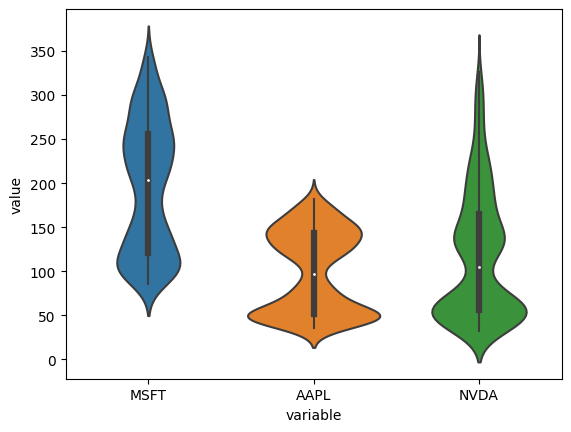

In [15]:
# 가격들의 분포 알아보기(violin plot으로 시각화)

import seaborn as sns
import pandas as pd

# melt를 이용해 3개의 그래프를 한 번에 그리기

melt_stocks = stocks.reset_index().melt(id_vars = ['Date'])
sns.violinplot(data=melt_stocks, x='variable', y='value')

<AxesSubplot: ylabel='Frequency'>

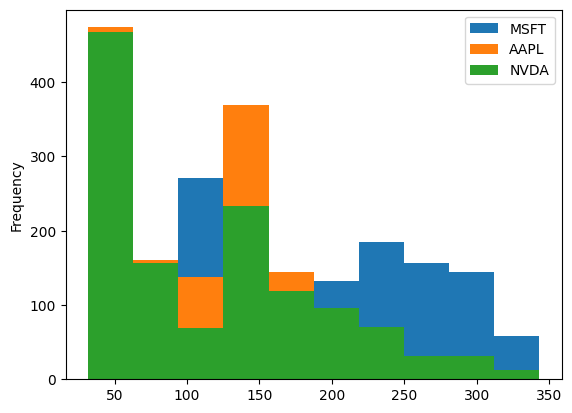

In [16]:
# melt_stocks histogram

stocks.plot.hist(alpha=0.5)

### 정규화

In [18]:
# normalization (시작점으로 나눠줌)

normalization = (stocks / stocks.iloc[0]) * 100
normalization.head()

,MSFT,AAPL,NVDA
Date,,,
2018-01-02,100.000000,100.000000,100.000000
2018-01-03,100.465388,99.982584,106.581385
2018-01-04,101.349627,100.447001,107.143209
2018-01-05,102.606172,101.590621,108.051158
2018-01-08,102.710881,101.213289,111.361922


<AxesSubplot: xlabel='Date'>

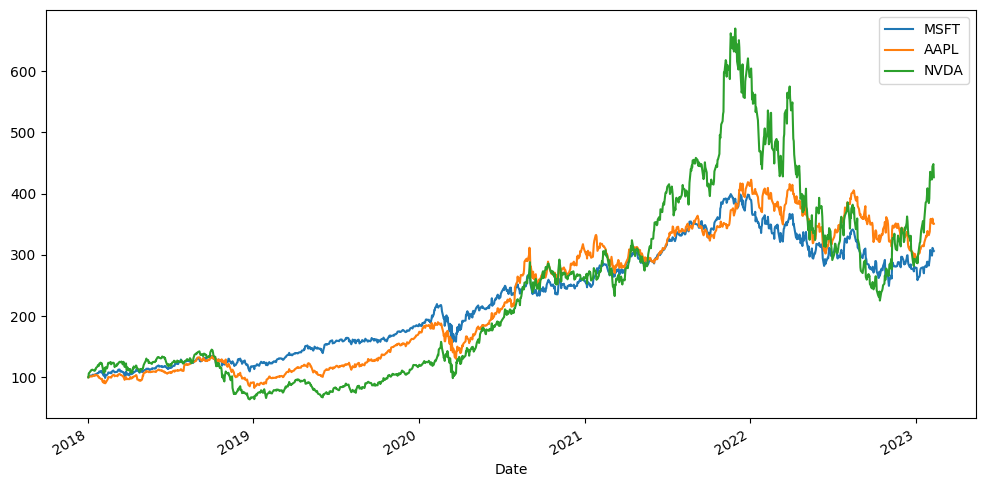

In [19]:
# 시각화

normalization.plot(figsize = (12, 6))

In [20]:
# 로그 수익률을 시각화

log_close = np.log(stocks)
log_close.head()

,MSFT,AAPL,NVDA
Date,,,
2018-01-02,4.453766,3.762711,3.908768
2018-01-03,4.458409,3.762536,3.972506
2018-01-04,4.467172,3.767171,3.977764
2018-01-05,4.479494,3.778492,3.986202
2018-01-08,4.480514,3.774770,4.016383


<AxesSubplot: xlabel='Date'>

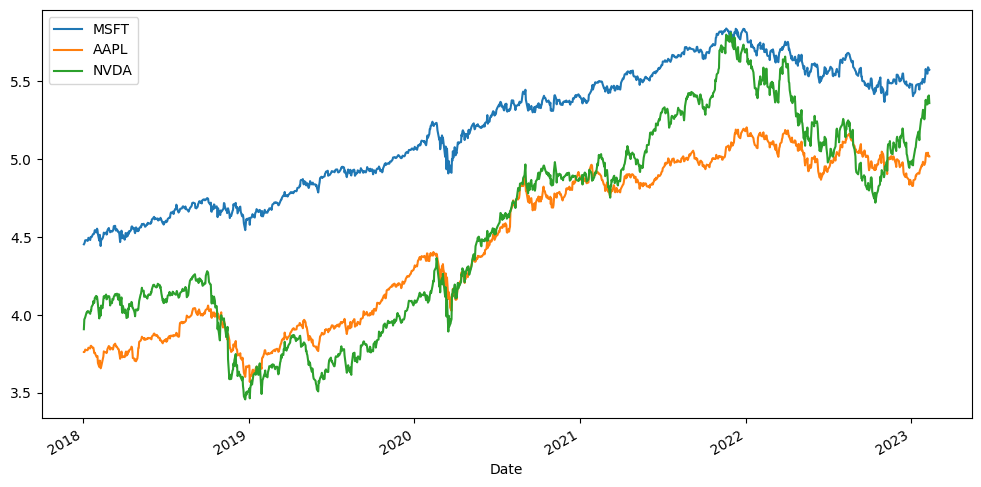

In [21]:
log_close.plot(figsize = (12, 6))

In [24]:
# 수익률

returns = stocks.pct_change() * 100
returns.tail()

,MSFT,AAPL,NVDA
Date,,,
2023-02-06,-0.611580,-1.792883,-0.052133
2023-02-07,4.202208,1.924470,5.140119
2023-02-08,-0.310206,-1.765274,0.144323
2023-02-09,-1.165979,-0.691155,0.594457
2023-02-10,-0.197249,0.092795,-4.799213


<AxesSubplot: ylabel='Frequency'>

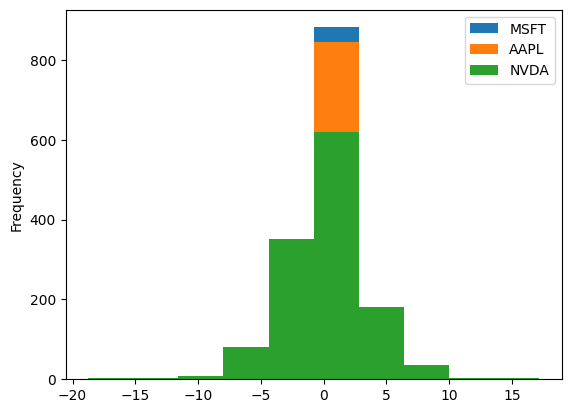

In [25]:
returns.plot.hist()

### 월별수익률

In [30]:
# 월초 기준으로 resample하여 마지막 값(종가)을 가져온다.

monthly_price = stocks.resample('MS').last()
monthly_price.head()

,MSFT,AAPL,NVDA
Date,,,
2018-01-01,95.010002,41.857498,61.450001
2018-02-01,93.769997,44.529999,60.500000
2018-03-01,91.269997,41.945000,57.897499
2018-04-01,93.519997,41.314999,56.224998
2018-05-01,98.839996,46.717499,63.047501


In [31]:
# 월별 수익률(종가) 구하기

monthly_return_rate = monthly_price.pct_change() * 100
monthly_return_rate.tail()

,MSFT,AAPL,NVDA
Date,,,
2022-10-01,-0.330609,10.955137,11.187085
2022-11-01,9.912546,-3.462891,25.383415
2022-12-01,-6.004543,-12.227255,-13.644151
2023-01-01,3.331662,11.052106,33.686873
2023-02-01,6.170053,4.657289,8.844756


In [33]:
# melt 사용

melt_monthly_stocks = monthly_return_rate.reset_index().melt(id_vars = ['Date'])
melt_monthly_stocks

,Date,variable,value
0,2018-01-01,MSFT,NaN
1,2018-02-01,MSFT,-1.305131
2,2018-03-01,MSFT,-2.666098
3,2018-04-01,MSFT,2.465213
4,2018-05-01,MSFT,5.688622
...,...,...,...
181,2022-10-01,NVDA,11.187085
182,2022-11-01,NVDA,25.383415
183,2022-12-01,NVDA,-13.644151
184,2023-01-01,NVDA,33.686873


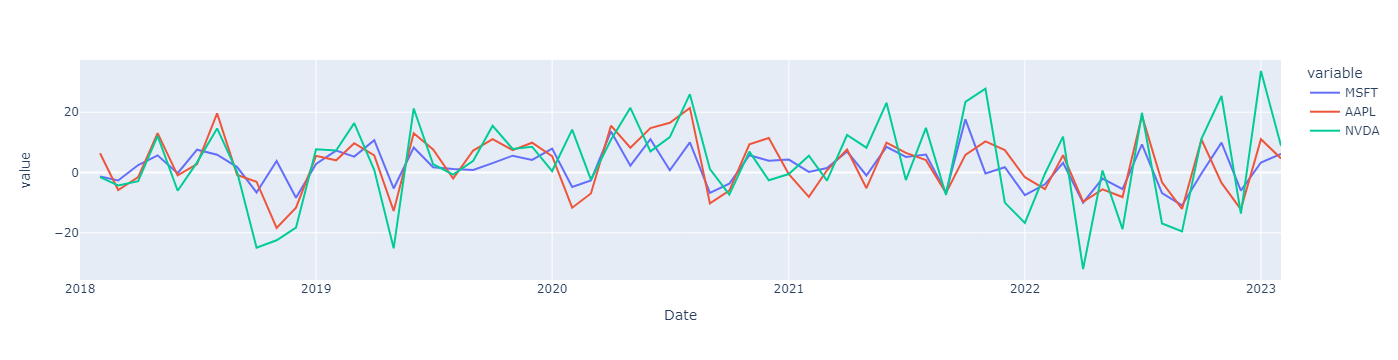

In [46]:
# line chart로 그리기

import plotly.express as px

fig = px.line(melt_monthly_stocks, x='Date', y="value", color='variable')
fig.show()

<AxesSubplot: xlabel='variable', ylabel='value'>

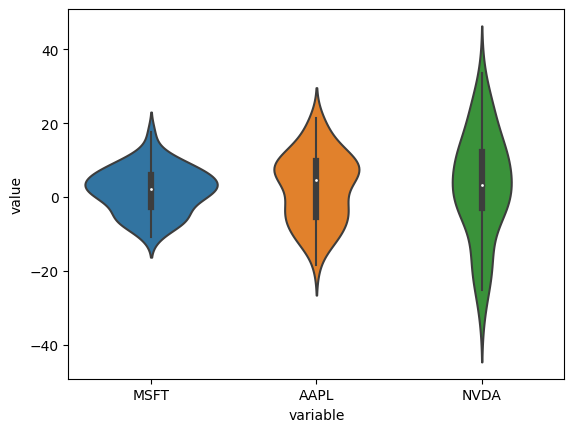

In [48]:
sns.violinplot(data = melt_monthly_stocks, x='variable', y='value')

In [50]:
# 일평균 수익률 구하기

일평균수익률 = returns.mean()     # %
일평균수익률

MSFT    0.106261
AAPL    0.119709
NVDA    0.166950
dtype: float64

In [53]:
# risk(표준편차로) 확인하기 - 높을 수록 risk가 큼

표준편차 = returns.std()
표준편차

MSFT    1.960910
AAPL    2.102408
NVDA    3.279501
dtype: float64

In [54]:
# 연평균수익률 구하기 (주말, 공휴일 빼고 1년에 보통 252일로 계산)

연평균수익률 = 일평균수익률 * 252
연평균수익률

MSFT    26.777705
AAPL    30.166655
NVDA    42.071379
dtype: float64

In [55]:
# 연표준편차

연표준편차 = 표준편차 * 252
연표준편차

MSFT    494.149361
AAPL    529.806861
NVDA    826.434303
dtype: float64

In [56]:
# 연평균수익률, 연표준편차 column 추가하고 컬럼의 이름 변경

return_risk = pd.concat([연평균수익률, 연표준편차], axis = 1) 
return_risk.columns = ['Return', 'Risk']
return_risk.head()

,Return,Risk
MSFT,26.777705,494.149361
AAPL,30.166655,529.806861
NVDA,42.071379,826.434303


In [59]:
melt_return_risk = return_risk.reset_index().melt(id_vars = 'index')
melt_return_risk

,index,variable,value
0,MSFT,Return,26.777705
1,AAPL,Return,30.166655
2,NVDA,Return,42.071379
3,MSFT,Risk,494.149361
4,AAPL,Risk,529.806861
5,NVDA,Risk,826.434303


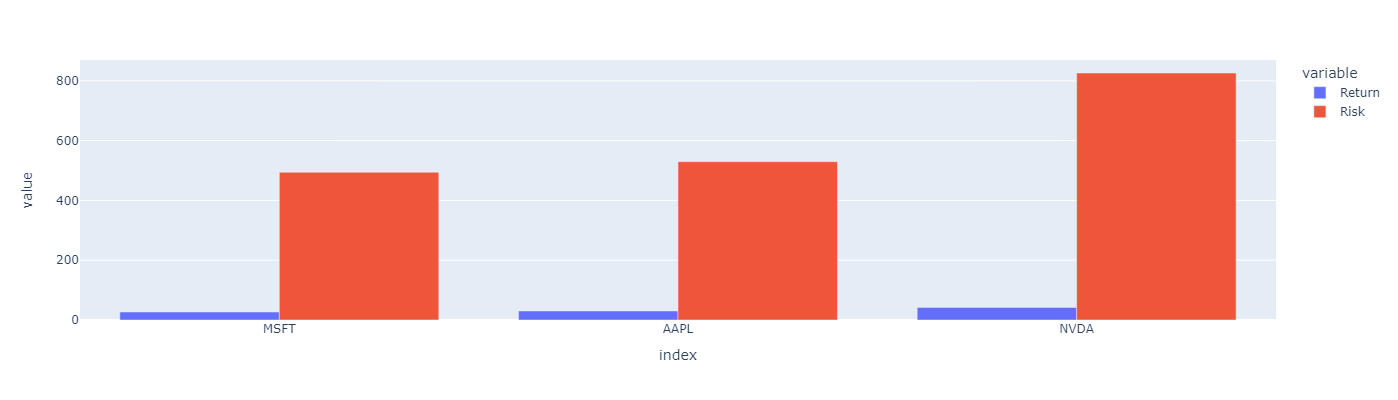

In [62]:
# 시각화 (bar plot)

import plotly.express as px

fig = px.bar(melt_return_risk, x='index', y='value',
             color='variable', barmode='group',
             height=400)
fig.show()

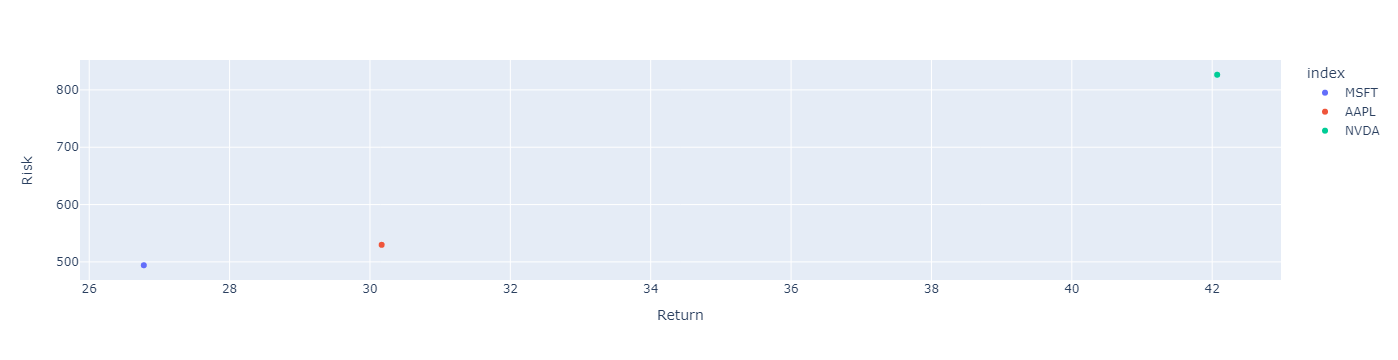

In [68]:
# 시각화 (scatter)

fig = px.scatter(return_risk, x=return_risk.Return, y=return_risk.Risk, color=return_risk.index,
                 hover_data=[return_risk.index])
fig.show()

In [75]:
# 누적수익률 (returns가 *100이므로)

return_rate = returns/100

cum_returns = (return_rate + 1).cumprod() - 1
cum_returns.tail()

,MSFT,AAPL,NVDA
Date,,,
2023-02-06,1.987435,2.523279,3.231552
2023-02-07,2.112973,2.591083,3.449059
2023-02-08,2.103316,2.527691,3.455480
2023-02-09,2.067132,2.503309,3.481966
2023-02-10,2.061082,2.506560,3.266867


<AxesSubplot: xlabel='Date'>

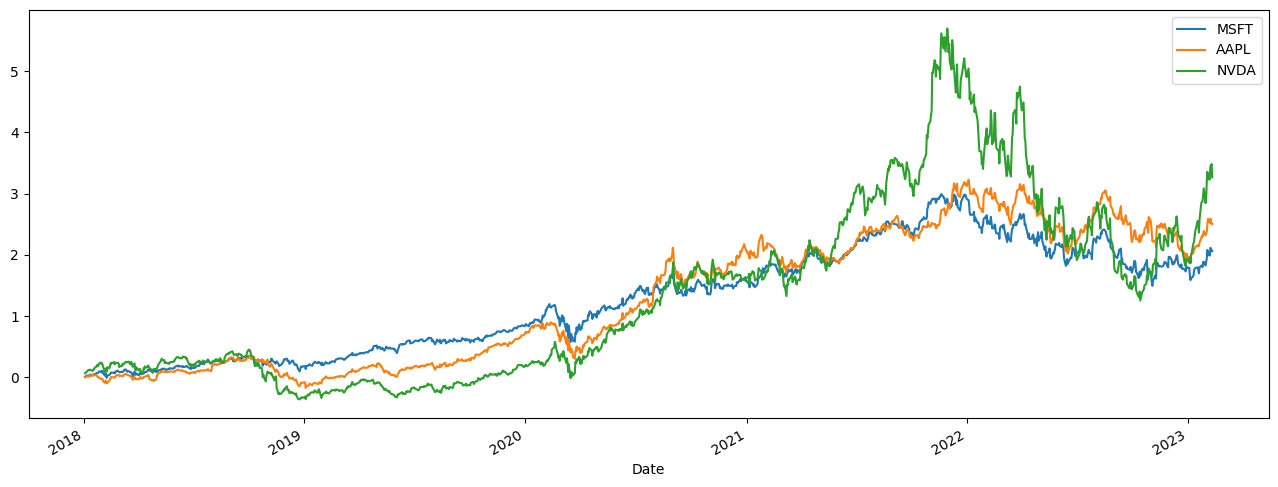

In [73]:
# 누적 수익률 시각화

cum_returns.plot(figsize = (16, 6))

In [77]:
# 공분산 구하기 (cov())

return_rate.cov()

,MSFT,AAPL,NVDA
MSFT,0.000385,0.000316,0.000461
AAPL,0.000316,0.000442,0.000457
NVDA,0.000461,0.000457,0.001076


In [78]:
# 상관계수 구하기 (corr()) --중요!!

return_rate.corr()

,MSFT,AAPL,NVDA
MSFT,1.000000,0.766532,0.716208
AAPL,0.766532,1.000000,0.662715
NVDA,0.716208,0.662715,1.000000


In [82]:
# style.background_gradient 표현 - 1에 가까울수록 빨강, 상관계수가 낮을수록 파랑에 가까움

return_rate.corr().style.background_gradient(cmap='coolwarm')

,MSFT,AAPL,NVDA
MSFT,1.000000,0.766532,0.716208
AAPL,0.766532,1.000000,0.662715
NVDA,0.716208,0.662715,1.000000


<AxesSubplot: xlabel='MSFT', ylabel='AAPL'>

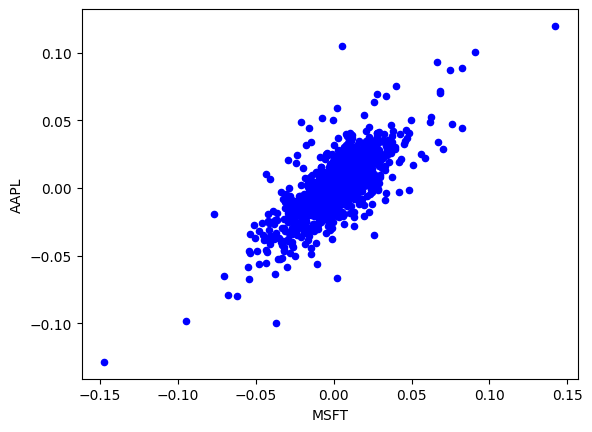

In [83]:
# 'MSFT'와 'AAPL'의 수익률 간의 상관관계 산점도로 그래프

return_rate.plot.scatter(x='MSFT', y='AAPL', c='blue')

<AxesSubplot: xlabel='MSFT', ylabel='AAPL'>

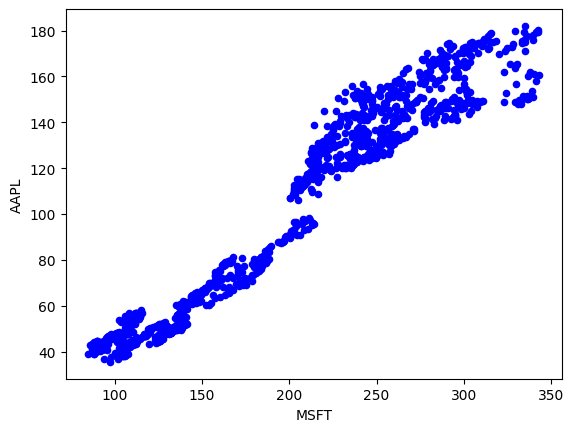

In [85]:
# 'MSFT'와 'AAPL'의 가격 간의 상관관계 산점도로 그래프

stocks.plot.scatter(x='MSFT', y='AAPL', c='blue')

array([[<AxesSubplot: xlabel='MSFT', ylabel='MSFT'>,
        <AxesSubplot: xlabel='AAPL', ylabel='MSFT'>,
        <AxesSubplot: xlabel='NVDA', ylabel='MSFT'>],
       [<AxesSubplot: xlabel='MSFT', ylabel='AAPL'>,
        <AxesSubplot: xlabel='AAPL', ylabel='AAPL'>,
        <AxesSubplot: xlabel='NVDA', ylabel='AAPL'>],
       [<AxesSubplot: xlabel='MSFT', ylabel='NVDA'>,
        <AxesSubplot: xlabel='AAPL', ylabel='NVDA'>,
        <AxesSubplot: xlabel='NVDA', ylabel='NVDA'>]], dtype=object)

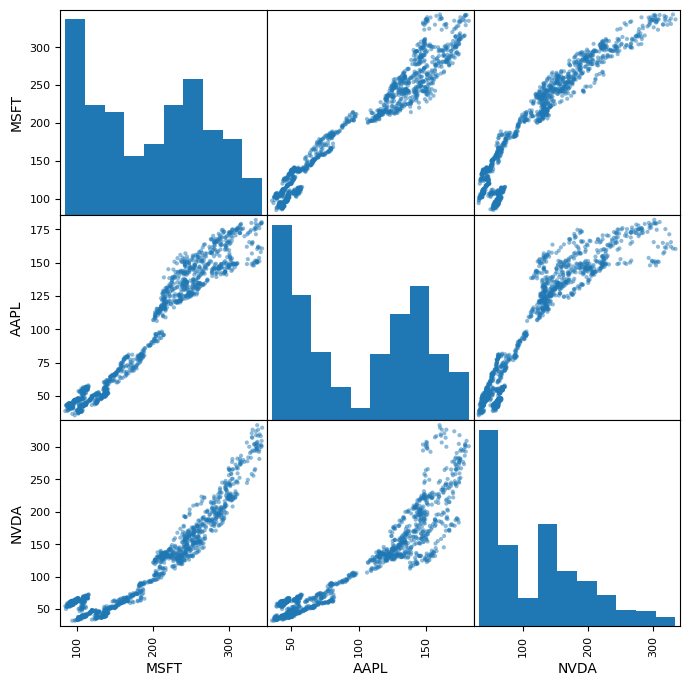

In [86]:
# stocks를 pandas에서 산점도 그래프 그리기

from pandas.plotting import scatter_matrix

scatter_matrix(stocks, figsize = (8, 8))

In [87]:
# 이동평균 (5일, NaN값 제거)

stocks.rolling(5).mean().dropna()

,MSFT,AAPL,NVDA
Date,,,
2018-01-08,87.175999,43.343500,53.140500
2018-01-09,87.630000,43.447000,54.270000
2018-01-10,87.924001,43.550000,54.830499
2018-01-11,88.118001,43.662500,55.354999
2018-01-12,88.400000,43.767000,55.734000
...,...,...,...
2023-02-06,256.056000,149.353998,208.755997
2023-02-07,260.006000,151.425998,214.027997
2023-02-08,262.802002,152.723999,216.551999


In [88]:
# 지수가중이동평균 (최근 데이터에 가중치를 주는)

stocks.ewm(span = 10).mean()

,MSFT,AAPL,NVDA
Date,,,
2018-01-02,85.949997,43.064999,49.837502
2018-01-03,86.169998,43.060874,51.641501
2018-01-04,86.547873,43.139916,52.347400
2018-01-05,87.088881,43.340912,52.842439
2018-01-08,87.430819,43.411701,53.605353
...,...,...,...
2023-02-06,251.363340,146.724609,201.502904
2023-02-07,254.308187,148.165588,205.180557
2023-02-08,256.566700,148.848208,208.247729


In [90]:
# 이동평균과 지수가중이동평균 (100일)

SMA = stocks.rolling(100).mean().dropna()
EWMA = stocks.ewm(span = 100).mean().dropna()

<AxesSubplot: xlabel='Date'>

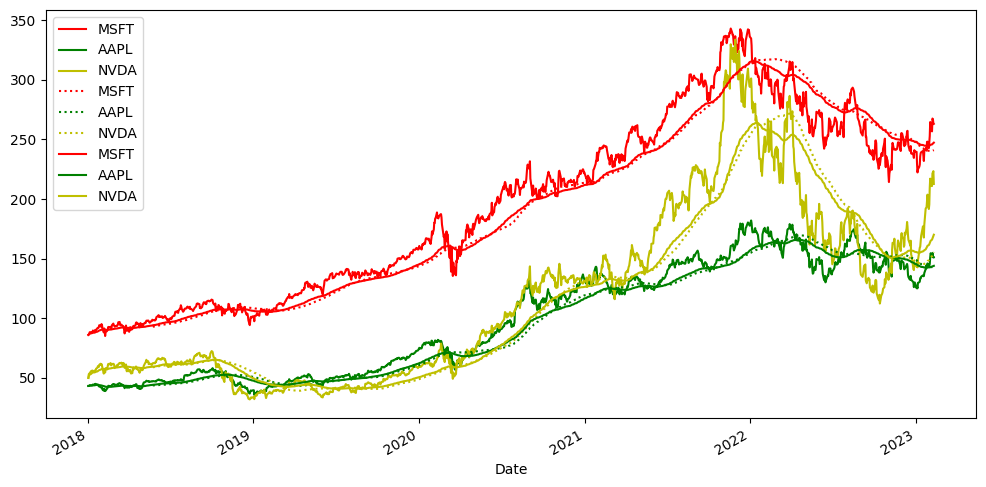

In [93]:
# 시각화

ax = stocks.plot(figsize = (12, 6), style = {'MSFT': 'r', 'AAPL': 'g', 'NVDA': 'y'})   # 종가
SMA.plot(figsize = (12, 6), ax = ax, style = {'MSFT': ':r', 'AAPL': ':g', 'NVDA': ':y'})
EWMA.plot(figsize = (12, 6), ax = ax, style = {'MSFT': 'r', 'AAPL': 'g', 'NVDA': 'y'})

### [실습]

In [2]:
KOSPI = fdr.DataReader('KS11', '2016')[['Close']].rename(columns = {'Close':'KOSPI'})
NASDAQ = fdr.DataReader('IXIC', '2016')[['Close']].rename(columns = {'Close':'NASDAQ'})
SnP500 = fdr.DataReader('US500', '2016')[['Close']].rename(columns = {'Close':'SnP500'})
GOLD = fdr.DataReader('ZG', '2016')[['Close']].rename(columns = {'Close':'Gold'})       # 금선물
BTC = fdr.DataReader('BTC/KRW', '2016')[['Close']].rename(columns = {'Close':'BTC/KRW'}) # 비트코인

In [ ]:
# 평균 수익률, 리스크 비교
# 지수별 상관관계 비교 & 시각화
# 가격, 수익률 분포 확인
# 월별 수익률 분포 확인

In [6]:
# 모든 컬럼 concat
index_1 = pd.concat([KOSPI, NASDAQ, SnP500, GOLD, BTC], axis = 1).dropna()
index_1

,KOSPI,NASDAQ,SnP500,Gold,BTC/KRW
Date,,,,,
2016-01-04,1918.760010,4903.089844,2012.660034,24.510000,5.146464e+05
2016-01-05,1930.530029,4891.430176,2016.709961,24.040001,5.139287e+05
2016-01-06,1925.430054,4835.759766,1990.260010,23.879999,5.148230e+05
2016-01-07,1904.329956,4689.430176,1943.089966,23.020000,5.481002e+05
2016-01-08,1917.619995,4643.629883,1922.030029,23.889999,5.470214e+05
...,...,...,...,...,...
2023-02-07,2451.709961,12113.790039,4164.000000,45.470001,2.921297e+07
2023-02-08,2483.639893,11910.519531,4117.859863,43.799999,2.892303e+07
2023-02-09,2481.520020,11789.580078,4081.500000,42.630001,2.759890e+07


In [7]:
# 단순 수익률

returns_1 = index_1.pct_change() * 100
returns_1.tail()

,KOSPI,NASDAQ,SnP500,Gold,BTC/KRW
Date,,,,,
2023-02-07,0.554511,1.904023,1.287251,3.317435,1.740806
2023-02-08,1.302354,-1.678009,-1.108072,-3.672756,-0.992518
2023-02-09,-0.085353,-1.015400,-0.882980,-2.671228,-4.578089
2023-02-10,-0.475114,-0.606128,0.219526,-0.961764,-0.528862
2023-02-13,-0.689550,1.482063,1.144861,4.571295,1.147760


In [8]:
# 일평균수익률

day_returns = returns_1.mean()
day_returns

KOSPI      0.020469
NASDAQ     0.063215
SnP500     0.050439
Gold       0.101251
BTC/KRW    0.345535
dtype: float64

In [9]:
# risk(표준편차)

risk_1 = returns_1.std()
risk_1

KOSPI      1.088181
NASDAQ     1.460873
SnP500     1.241665
Gold       3.629122
BTC/KRW    4.660876
dtype: float64

In [10]:
# 연평균수익률

year_returns = day_returns * 252
year_returns

KOSPI       5.158279
NASDAQ     15.930139
SnP500     12.710710
Gold       25.515135
BTC/KRW    87.074873
dtype: float64

In [49]:
# 연표준편차

year_risk = risk_1 * 252
year_risk

KOSPI       274.221586
NASDAQ      368.139939
SnP500      312.899683
Gold        914.538667
BTC/KRW    1174.540679
dtype: float64

In [11]:
return_rate_1 = returns_1 / 100

In [12]:
# 누적 수익률

cum_returns_1  = (return_rate_1 + 1).cumprod() - 1
cum_returns_1

,KOSPI,NASDAQ,SnP500,Gold,BTC/KRW
Date,,,,,
2016-01-04,NaN,NaN,NaN,NaN,NaN
2016-01-05,0.006134,-0.002378,0.002012,-0.019176,-0.001394
2016-01-06,0.003476,-0.013732,-0.011130,-0.025704,0.000343
2016-01-07,-0.007521,-0.043577,-0.034566,-0.060792,0.065004
2016-01-08,-0.000594,-0.052918,-0.045030,-0.025296,0.062907
...,...,...,...,...,...
2023-02-07,0.277757,1.470644,1.068904,0.855161,55.763190
2023-02-08,0.294398,1.429186,1.045979,0.787026,55.199805
2023-02-09,0.293294,1.404521,1.027913,0.739290,52.626928


In [13]:
returns_1

,KOSPI,NASDAQ,SnP500,Gold,BTC/KRW
Date,,,,,
2016-01-04,NaN,NaN,NaN,NaN,NaN
2016-01-05,0.613418,-0.237802,0.201223,-1.917581,-0.139446
2016-01-06,-0.264175,-1.138121,-1.311540,-0.665566,0.174015
2016-01-07,-1.095864,-3.025990,-2.370044,-3.601336,6.463817
2016-01-08,0.697885,-0.976671,-1.083837,3.779318,-0.196828
...,...,...,...,...,...
2023-02-07,0.554511,1.904023,1.287251,3.317435,1.740806
2023-02-08,1.302354,-1.678009,-1.108072,-3.672756,-0.992518
2023-02-09,-0.085353,-1.015400,-0.882980,-2.671228,-4.578089


In [14]:
# 정규화 후 비교

normalization_1 = (returns_1 / returns_1.iloc[1]) * 100
normalization_1

,KOSPI,NASDAQ,SnP500,Gold,BTC/KRW
Date,,,,,
2016-01-04,NaN,NaN,NaN,NaN,NaN
2016-01-05,100.000000,100.000000,100.000000,100.000000,100.000000
2016-01-06,-43.066044,478.599486,-651.785442,34.708617,-124.789734
2016-01-07,-178.648848,1272.480410,-1177.822082,187.806241,-4635.338996
2016-01-08,113.769946,410.706758,-538.626090,-197.087832,141.149199
...,...,...,...,...,...
2023-02-07,90.396849,-800.674447,639.714930,-173.001065,-1248.368832
2023-02-08,212.310952,705.631561,-550.669961,191.530704,711.755546
2023-02-09,-13.914407,426.993202,-438.807360,139.302014,3283.044127


<AxesSubplot: ylabel='Frequency'>

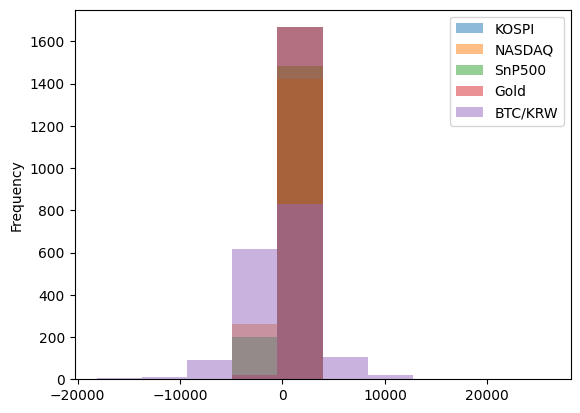

In [47]:
# 시각화

normalization_1.plot.hist(alpha=0.5)

In [29]:
# 지수별 상관관계 비교 & 시각화

returns_1.corr().style.background_gradient(cmap='coolwarm')

,KOSPI,NASDAQ,SnP500,Gold,BTC/KRW
KOSPI,1.000000,0.215142,0.258232,0.172617,-0.022483
NASDAQ,0.215142,1.000000,0.945954,0.538335,0.188016
SnP500,0.258232,0.945954,1.000000,0.476618,0.169779
Gold,0.172617,0.538335,0.476618,1.000000,0.132179
BTC/KRW,-0.022483,0.188016,0.169779,0.132179,1.000000


array([[<AxesSubplot: xlabel='KOSPI', ylabel='KOSPI'>,
        <AxesSubplot: xlabel='NASDAQ', ylabel='KOSPI'>,
        <AxesSubplot: xlabel='SnP500', ylabel='KOSPI'>,
        <AxesSubplot: xlabel='Gold', ylabel='KOSPI'>,
        <AxesSubplot: xlabel='BTC/KRW', ylabel='KOSPI'>],
       [<AxesSubplot: xlabel='KOSPI', ylabel='NASDAQ'>,
        <AxesSubplot: xlabel='NASDAQ', ylabel='NASDAQ'>,
        <AxesSubplot: xlabel='SnP500', ylabel='NASDAQ'>,
        <AxesSubplot: xlabel='Gold', ylabel='NASDAQ'>,
        <AxesSubplot: xlabel='BTC/KRW', ylabel='NASDAQ'>],
       [<AxesSubplot: xlabel='KOSPI', ylabel='SnP500'>,
        <AxesSubplot: xlabel='NASDAQ', ylabel='SnP500'>,
        <AxesSubplot: xlabel='SnP500', ylabel='SnP500'>,
        <AxesSubplot: xlabel='Gold', ylabel='SnP500'>,
        <AxesSubplot: xlabel='BTC/KRW', ylabel='SnP500'>],
       [<AxesSubplot: xlabel='KOSPI', ylabel='Gold'>,
        <AxesSubplot: xlabel='NASDAQ', ylabel='Gold'>,
        <AxesSubplot: xlabel='SnP500', ylabe

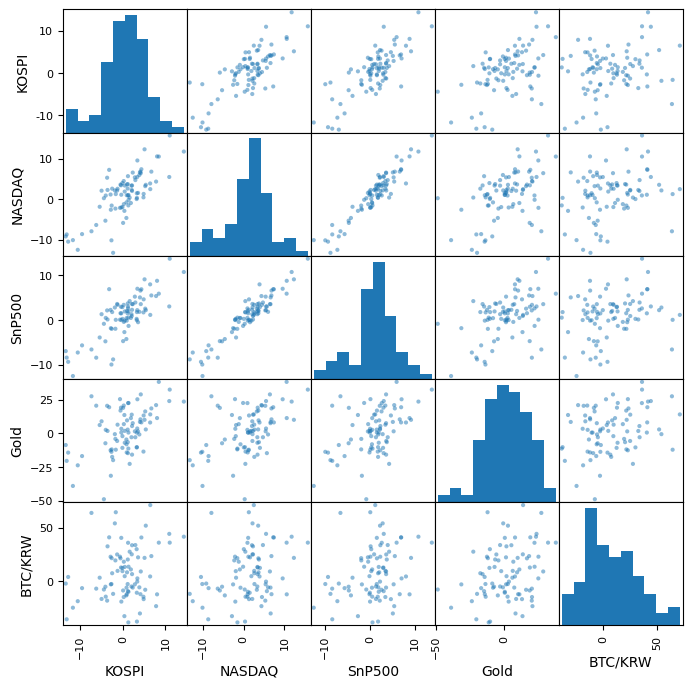

In [53]:
# 지수별 월별 수익률 scatter

from pandas.plotting import scatter_matrix

scatter_matrix(monthly_return_rate_1, figsize = (8, 8))     # 그래프에서 SnP500과 NASDAQ, NASDQ과 KOSPI 지수는 확연하게 양의 상관관계를 가지는 것을 확인할 수 있다. 포트폴리오 측면에서 SnP500과 NASDAQ, NASDQ과 KOSPI 지수는 별 의미가 없어 보인다.

In [128]:
SMA_1 = returns_1.rolling(5).mean().dropna()
SMA_1

,KOSPI,NASDAQ,SnP500,Gold,BTC/KRW
Date,,,,,
2016-01-11,-0.247334,-1.100007,-0.895774,-0.589864,1.002175
2016-01-12,-0.412026,-0.845763,-0.779963,-0.315777,0.549252
2016-01-13,-0.090318,-1.300438,-1.016964,-0.715883,0.393435
2016-01-14,-0.040954,-0.302227,-0.209037,-0.308660,-1.061557
2016-01-15,-0.403056,-0.655452,-0.424251,-1.364877,-3.998433
...,...,...,...,...,...
2023-02-06,-0.094615,0.868896,0.465981,0.895222,0.418267
2023-02-07,0.223512,0.914887,0.430582,1.188865,0.492901
2023-02-08,0.280113,0.179148,-0.000078,0.063253,-0.039832


In [38]:
# 월별 가격(월초 마지막 데이터) 분포 확인

monthly_price_1 = index_1.resample('MS').last()
monthly_price_1

,KOSPI,NASDAQ,SnP500,Gold,BTC/KRW
Date,,,,,
2016-01-01,1912.060059,4613.950195,1940.239990,21.670000,4.580668e+05
2016-02-01,1916.660034,4557.950195,1932.229980,23.150000,5.413392e+05
2016-03-01,1995.849976,4869.850098,2059.739990,25.549999,4.758628e+05
2016-04-01,1994.150024,4775.359863,2065.300049,25.020000,5.205536e+05
2016-05-01,1983.400024,4948.049805,2096.949951,29.240000,6.314938e+05
...,...,...,...,...,...
2022-10-01,2293.610107,10988.150391,3871.979980,30.930000,2.922021e+07
2022-11-01,2472.530029,11468.000000,4080.110107,37.400002,2.242867e+07
2022-12-01,2236.399902,10478.089844,3849.280029,31.100000,2.098034e+07


In [39]:
melt_monthly_price_1 = monthly_return_rate_1.reset_index().melt(id_vars = 'Date')

<AxesSubplot: xlabel='variable', ylabel='value'>

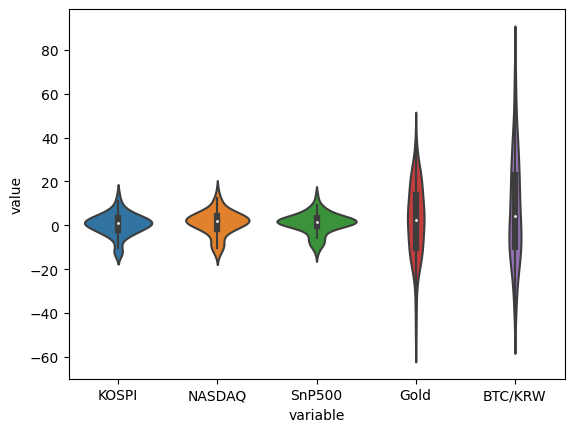

In [41]:
sns.violinplot(data = melt_monthly_price_1, x = 'variable', y = 'value')

In [31]:
# 월 별 수익률, 시각화

monthly_return_rate_1 = monthly_price_1.pct_change() * 100
monthly_return_rate_1

,KOSPI,NASDAQ,SnP500,Gold,BTC/KRW
Date,,,,,
2016-01-01,NaN,NaN,NaN,NaN,NaN
2016-02-01,0.240577,-1.213711,-0.412836,6.829719,18.179095
2016-03-01,4.131663,6.842986,6.599111,10.367166,-12.095263
2016-04-01,-0.085174,-1.940311,0.269940,-2.074360,9.391519
2016-05-01,-0.539077,3.616271,1.532460,16.866507,21.311969
...,...,...,...,...,...
2022-10-01,6.407829,3.900767,7.986341,8.033535,4.409180
2022-11-01,7.800799,4.366973,5.375289,20.918209,-23.242612
2022-12-01,-9.550142,-8.631934,-5.657447,-16.844924,-6.457485


In [32]:
melt_monthly_stocks_1 = monthly_return_rate_1.reset_index().melt(id_vars = 'Date')
melt_monthly_stocks_1

,Date,variable,value
0,2016-01-01,KOSPI,NaN
1,2016-02-01,KOSPI,0.240577
2,2016-03-01,KOSPI,4.131663
3,2016-04-01,KOSPI,-0.085174
4,2016-05-01,KOSPI,-0.539077
...,...,...,...
425,2022-10-01,BTC/KRW,4.409180
426,2022-11-01,BTC/KRW,-23.242612
427,2022-12-01,BTC/KRW,-6.457485
428,2023-01-01,BTC/KRW,35.938451


<AxesSubplot: xlabel='variable', ylabel='value'>

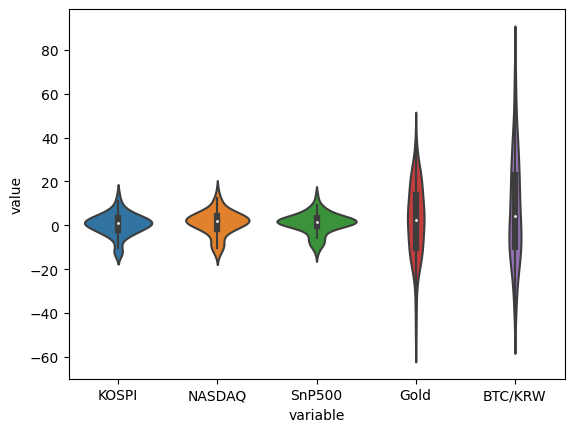

In [34]:
import seaborn as sns

sns.violinplot(data = melt_monthly_stocks_1, x = 'variable', y = 'value')